## TOC:
* [Setup](#first-bullet)
* [Vision Transformer (ViT)](#second-bullet)
* [Mask Generation](#third-bullet)
* [Image Similarity Search](#forth-bullet)
* [SAM](#fifth-bullet)
* [Datasets and Metrics](#eigth-bullet)
* [TLDR](#last-bullet)

## Setup <a class="anchor" id="first-bullet"></a>

In [16]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer, util


## Vision Transformer (ViT) <a class="anchor" id="second-bullet"></a>

## What is the Vision Transformer?

The Vision Transformer (ViT) is a neural network architecture that applies the **transformer model**, originally developed for natural language processing (NLP), to computer vision tasks like image classification. Introduced in 2020 by Dosovitskiy et al., ViT fundamentally changes the way images are processed by forgoing convolutional layers (as in CNNs) in favor of **self-attention mechanisms**.

The core idea behind ViT is to split an image into fixed-size patches (akin to words in a text), embed them, and then process these embeddings using a standard transformer encoder. This approach contrasts with convolutional neural networks (CNNs), which process images hierarchically using convolutional kernels.

---

## Key Ideas Behind Vision Transformers

1. **Patch-based Representation**:
   - Images are divided into non-overlapping patches (e.g., $16 \times 16$ pixels).
   - Each patch is treated as a "token," analogous to a word in NLP.

2. **Positional Embeddings**:
   - To retain spatial information, positional embeddings are added to each patch embedding.

3. **Self-Attention**:
   - The transformer architecture uses self-attention to model global relationships between patches.

4. **Pretraining and Transfer Learning**:
   - ViTs often require large-scale pretraining on datasets like ImageNet-21k or JFT-300M because they lack the inductive biases of CNNs (e.g., local connectivity).

---

## Architecture of Vision Transformer

The ViT architecture can be divided into the following key components:

1. **Patch Embedding Layer**:
   - The input image ($H \times W \times C$) is divided into patches of size $P \times P$.
   - Each patch is flattened and projected into a feature space using a trainable linear projection.

   Mathematically:
   $$
   \text{PatchEmbedding}(x) = x_p \cdot W + b
   $$
   Where:
   - $x_p$: Flattened patch.
   - $W, b$: Learnable weights and biases.

2. **Positional Embeddings**:
   - A positional embedding vector is added to each patch embedding to incorporate spatial information.

   Formally:
   $$
   z_0^i = x_p^i + p^i
   $$
   Where $p^i$ is the positional embedding for the $i$-th patch.

3. **Transformer Encoder**:
   - The core transformer encoder consists of:
     - Multi-Head Self-Attention (MHSA):
       $$
       \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
       $$
       - $Q, K, V$: Query, Key, and Value matrices.
       - $d_k$: Dimensionality of key vectors.
     - Feedforward Neural Network (FFN): A two-layer perceptron applied to each patch embedding.

4. **Classification Token**:
   - A learnable `[CLS]` token is appended to the patch embeddings. Its final state is used for classification tasks.

5. **Classification Head**:
   - A simple MLP processes the `[CLS]` token to produce the final class probabilities.

---

## Differences Between ViT and NLP Transformer

| Aspect                    | NLP Transformer                                   | Vision Transformer (ViT)                         |
|---------------------------|--------------------------------------------------|--------------------------------------------------|
| **Input**                 | Tokenized text sequences                         | Patches of an image                              |
| **Tokenization**          | Words or subwords                                | Flattened pixel patches                         |
| **Positional Encoding**   | Sequential (1D)                                  | Spatial (2D flattened into 1D)                  |
| **Architecture Biases**   | Language structure (e.g., sequential dependency) | Minimal inductive bias (requires larger datasets) |
| **Data Requirements**     | Effective with smaller datasets                  | Requires large-scale pretraining                |

---

## Advantages of Vision Transformers

1. **Global Context**: Self-attention enables ViT to model long-range dependencies across an entire image.
2. **Scalability**: ViT scales well with larger datasets and higher computational resources.
3. **Simplicity**: Unlike CNNs, ViT doesn't rely on handcrafted architectural biases like convolutions.

### Challenges

1. **Data-Hungry**: ViT requires extensive pretraining on large datasets to outperform CNNs.
2. **Computational Cost**: The self-attention mechanism scales quadratically with the number of patches.

---

![image info](.\ViT_arhitecture.png "Title")

Source: <a href="https://arxiv.org/abs/2010.11929v2" > An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale </a>

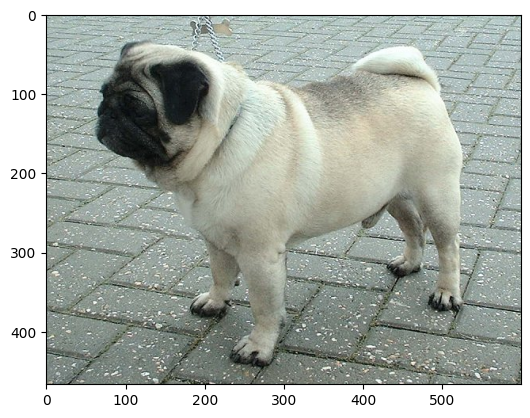

Predicted class: pug, pug-dog


In [ ]:
# Load pre-trained ViT model and processor
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load an example image
url = "https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Perform inference
outputs = model(**inputs)
predicted_class_idx = outputs.logits.argmax(-1).item()

imgplot = plt.imshow(image)
plt.show()
print("Predicted class:", model.config.id2label[predicted_class_idx])


## Mask Generation (ViT) <a class="anchor" id="third-bullet"></a>



## What is Mask Generation?

Mask generation refers to the process of creating binary or multi-class masks from an image. A **mask** highlights regions of interest within an image, often in the form of binary matrices where each pixel is assigned a label based on its class or membership to an object.

Mathematically, a binary mask $ M(x, y) $ for a 2D image $ I(x, y) $ is defined as:
$$
M(x, y) = 
\begin{cases} 
1, & \text{if } (x, y) \text{ belongs to the object of interest}, \\
0, & \text{otherwise.}
\end{cases}
$$

Mask generation is a foundational step in many computer vision tasks, such as:
- **Semantic segmentation**: Assigning a class label to every pixel in an image.
- **Instance segmentation**: Identifying individual objects and assigning unique labels to their pixels.
- **Panoptic segmentation**: Combining semantic and instance segmentation.

---

## Applications of Mask Generation

1. **Autonomous Driving**:
   - Identifying road lanes, pedestrians, vehicles, and other objects.
   - Example: Detecting road markings using binary masks.

2. **Medical Imaging**:
   - Segmenting tumors, organs, or blood vessels in radiological scans.
   - Example: Isolating a tumor from an MRI image.

3. **Image Editing**:
   - Extracting or replacing objects in an image.
   - Example: Removing the background from a portrait.

4. **Robotics**:
   - Enabling robots to identify and interact with objects in their environment.
   - Example: Segmenting graspable objects on a cluttered table.

---

## Techniques for Mask Generation

### 1. Thresholding
A simple approach based on pixel intensity. For a grayscale image $I(x, y)$, a binary mask can be generated using a threshold $T$:
$$
M(x, y) = 
\begin{cases} 
1, & \text{if } I(x, y) > T, \\
0, & \text{otherwise.}
\end{cases}
$$

### 2. Clustering-Based Methods (e.g., K-Means)
Groups pixels into clusters based on their intensity or color. Each cluster corresponds to a unique mask.

### 3. Edge Detection
Uses algorithms like **Canny** or **Sobel** to identify boundaries of objects, forming a mask around the edges.

### 4. Deep Learning Approaches
Leverages neural networks for pixel-level predictions:
   - **Fully Convolutional Networks (FCNs)**.
   - **U-Net**: Widely used in medical imaging.
   - **Mask R-CNN**: Extends Faster R-CNN for instance segmentation.

---

## Deep Learning for Mask Generation

### Fully Convolutional Networks (FCNs)
- Replaces fully connected layers with convolutional layers, allowing dense predictions for each pixel.

### U-Net Architecture
- A symmetric encoder-decoder network with skip connections.
- Encoder extracts features; decoder reconstructs the segmentation mask.

#### Mathematical Overview:
For an image $I$, U-Net models the mask $M$ as:
$$
M = f_\theta(I)
$$
Where $f_\theta$ is the U-Net model parameterized by $\theta$.

### Mask R-CNN
- Extends Faster R-CNN by adding a branch for predicting object masks.
- Produces masks, bounding boxes, and class labels simultaneously.

---

 100% |██████|    1.9Gb/1.9Gb [17.4s elapsed, 0s remaining, 126.7Mb/s]      
Extracting annotations to 'C:\Users\Gus\fiftyone\coco-2017\raw\instances_val2017.json'
 100% |██████████████████████| 5/5 [934.3ms elapsed, 0s remaining, 5.4 images/s]   
Writing annotations for 5 downloaded samples to 'C:\Users\Gus\fiftyone\coco-2017\validation\labels.json'
Dataset info written to 'C:\Users\Gus\fiftyone\coco-2017\info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████████| 5/5 [137.3ms elapsed, 0s remaining, 36.4 samples/s]     
Dataset 'coco-2017-validation-5' created



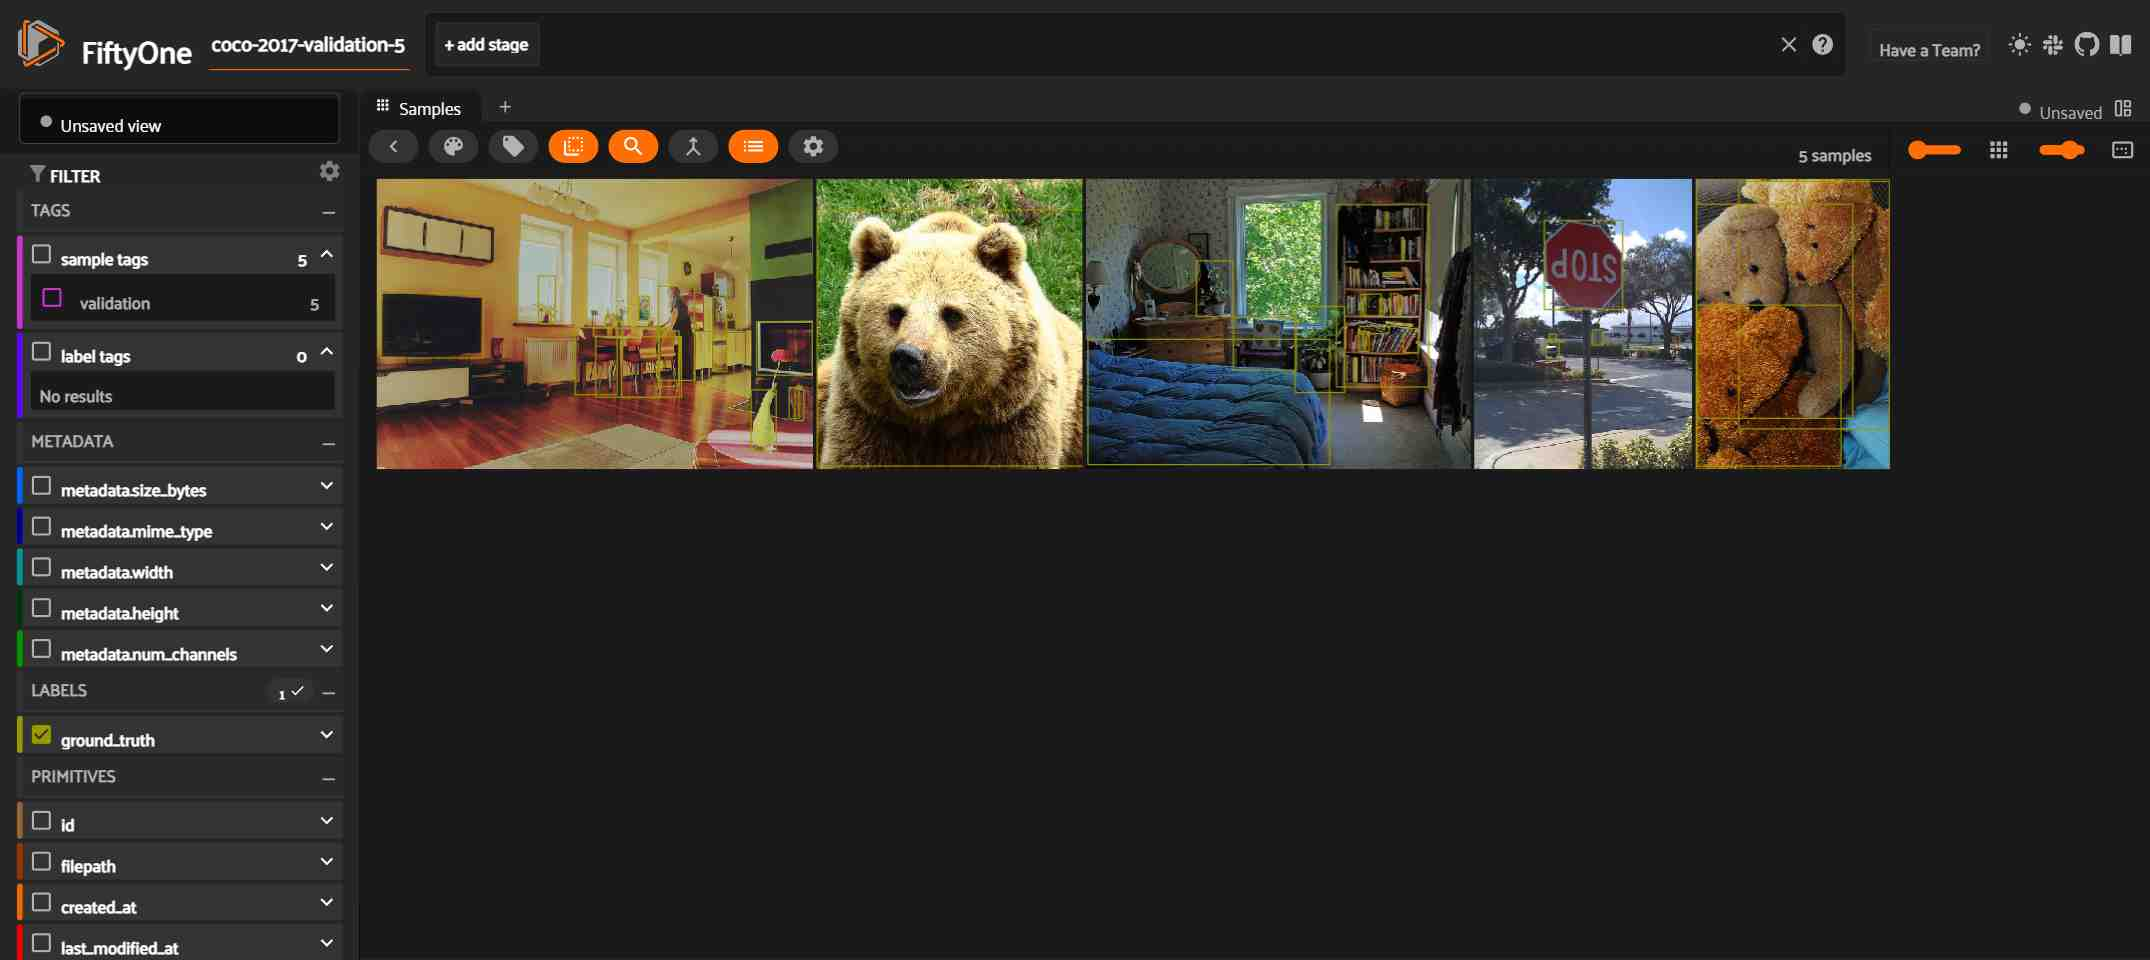


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.0.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [7]:
import fiftyone as fo
import fiftyone.zoo as foz
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample dataset
dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=5)

# Display the dataset in FiftyOne App
session = fo.launch_app(dataset)

e:\ProgramingTools\anaconda_gus\envs\conda_fii_cv_3\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


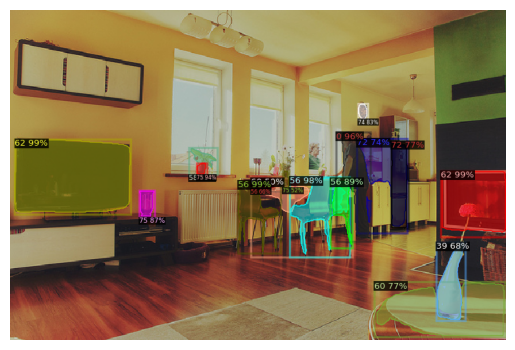

In [13]:
# Configure Detectron2 model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for predictions
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Load an image from the FiftyOne dataset
sample = dataset.first()
image_path = sample.filepath
image = Image.open(image_path)
image_np = np.array(image)

# Perform inference
outputs = predictor(image_np)


# Visualize the results
v = Visualizer(image_np, metadata=None, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

**Challenges in Mask Generation**
* Ambiguity:

    * Some objects lack clear boundaries, making segmentation difficult (e.g., overlapping objects).
* Computational Complexity:

    * Generating masks for high-resolution images requires significant computational resources.
* Dataset Dependency:

    * The performance of deep learning models heavily depends on the quality and size of the training dataset.

## Image Similarity Search <a class="anchor" id="forth-bullet"></a>

## What is Image Similarity Search?

Image similarity search involves finding images that are visually similar based on their content rather than metadata. This process compares the **features** of images, typically extracted using neural networks, to measure their similarity.

Mathematically, the task is to compare two images $I_1$ and $I_2$ and compute a similarity score $S$ based on their feature embeddings:
$$
S = \text{Similarity}(f(I_1), f(I_2))
$$
Where:
- $f(I)$: Feature extractor for image $I$.
- $\text{Similarity}(\cdot)$: A similarity metric, e.g., cosine similarity.

---

## Applications of Image Similarity Search

1. **E-commerce**:
   - Find visually similar products in online catalogs (e.g., fashion or furniture).

2. **Content Moderation**:
   - Detect duplicate or near-duplicate images in social media platforms.

3. **Image Deduplication**:
   - Identify and remove duplicate images in large datasets.

4. **Medical Imaging**:
   - Retrieve similar scans to aid in diagnosis.

---

## Techniques for Image Similarity Search

### 1. Feature Extraction

Feature extraction involves generating high-dimensional vector representations of images. Neural networks trained on large datasets (e.g., ResNet, ViT) are commonly used for this.

### 2. Dimensionality Reduction
To make similarity computation faster, feature embeddings can be reduced using:
- **Principal Component Analysis (PCA)**.
- **t-SNE** or **UMAP** for visualization.

### 3. Similarity Metrics
Common metrics for comparing feature embeddings include:
1. **Cosine Similarity**:
   $$
   S = \frac{f(I_1) \cdot f(I_2)}{\|f(I_1)\| \|f(I_2)\|}
   $$
   Where $S \in [-1, 1]$, with 1 indicating perfect similarity.
   
2. **Euclidean Distance**:
   $$
   D = \|f(I_1) - f(I_2)\|_2
   $$
   Lower values of $D$ imply higher similarity.

---

In [18]:
import torch

# Load a small dataset from FiftyOne
dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=5)

# Launch FiftyOne app (optional, to explore the dataset)
session = fo.launch_app(dataset)

# Extract file paths of the dataset samples
image_paths = [sample.filepath for sample in dataset]

# Load the pre-trained CLIP model
model = SentenceTransformer("clip-ViT-B-32")

# Compute embeddings for the images
embeddings = []
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")  # Ensure all images are in RGB
    img_embedding = model.encode(img, convert_to_tensor=True)
    embeddings.append(img_embedding)

# Stack the embeddings into a single tensor
embeddings_tensor = torch.stack(embeddings)

# Compute similarity matrix
similarities = util.pytorch_cos_sim(embeddings_tensor, embeddings_tensor)

# Display similarity matrix
print("Similarity Matrix:\n", similarities)

Found annotations at 'C:\Users\Gus\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-5'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Similarity Matrix:
 tensor([[1.0000, 0.6045, 0.7214, 0.4470, 0.6480],
        [0.6045, 1.0000, 0.5018, 0.4584, 0.7580],
        [0.7214, 0.5018, 1.0000, 0.4416, 0.5552],
        [0.4470, 0.4584, 0.4416, 1.0000, 0.4989],
        [0.6480, 0.7580, 0.5552, 0.4989, 1.0000]], device='cuda:0')


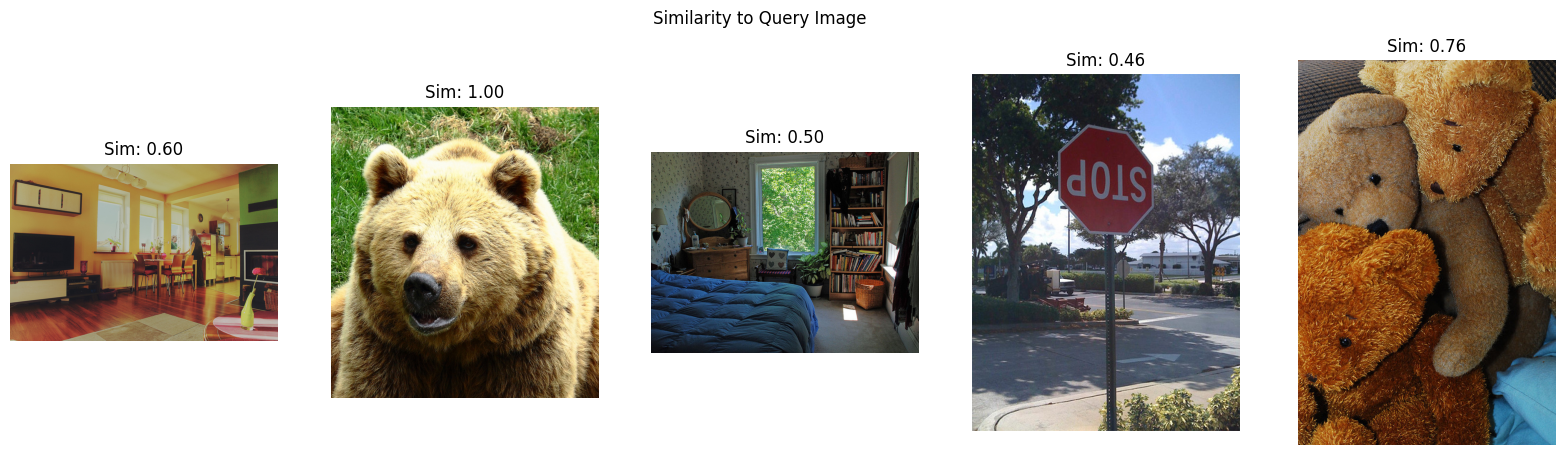

In [ ]:
# Visualize the images along with their similarity scores to the first image

query_idx = 1  # Index of the image with the bear
query_image = Image.open(image_paths[query_idx]).convert("RGB")

fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("RGB")
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Sim: {similarities[query_idx, i]:.2f}")
plt.suptitle("Similarity to Query Image")
plt.show()

**Challenges in Image Similarity Search**
* Feature Representation:
    * Extracting meaningful features is crucial for robust similarity matching.
* Scalability:
    * Comparing embeddings for millions of images requires efficient indexing structures (e.g., KD-trees, FAISS).
* Dataset Bias:
    * Similarity models trained on specific datasets may not generalize well to unseen domains.

**Optimizing Image Search with FAISS** \
For large-scale datasets, Facebook's FAISS (Facebook AI Similarity Search) library provides an efficient way to perform similarity searches.

In [ ]:
import faiss
# For windows pip install faiss-cpu

# Convert embeddings to a NumPy array
embeddings_np = np.stack([embedding.cpu().numpy() for embedding in embeddings])

# Create a FAISS index
index = faiss.IndexFlatL2(embeddings_np.shape[1])  # L2 for Euclidean distance
index.add(embeddings_np)  # Add embeddings to the index

# Perform a similarity search
query = embeddings_np[0]  # Use the first image as the query
distances, indices = index.search(query.reshape(1, -1), k=3)  # Retrieve top 3 matches
print("Top 3 similar images:", indices)

ModuleNotFoundError: No module named 'faiss'

## Segment Anything Model (SAM) <a class="anchor" id="fifth-bullet"></a>

## What is the Segment Anything Model (SAM)?

The **Segment Anything Model (SAM)**, introduced by Meta AI, is a general-purpose, foundational model for image segmentation. Unlike traditional segmentation models, SAM is designed to generalize across diverse segmentation tasks and datasets with minimal task-specific fine-tuning.

SAM is capable of segmenting objects based on **prompts**, such as:
1. **Points**: Click on a specific region.
2. **Bounding Boxes**: Enclose the object of interest.
3. **Masks**: Provide a rough initial mask.

---

## Architectural Overview

SAM consists of three main components:
1. **Image Encoder**:
   - A pre-trained **Vision Transformer (ViT)** is used as the backbone.
   - The encoder extracts rich, hierarchical image features.

2. **Prompt Encoder**:
   - Supports various input prompts (e.g., points, bounding boxes).
   - Lightweight encoders (e.g., MLPs) are used for embedding the prompts.

3. **Mask Decoder**:
   - Combines image and prompt embeddings.
   - Outputs segmentation masks along with uncertainty scores.

---

### SAM Pipeline

1. **Input Image**:
   - The input image is split into patches and processed by the Vision Transformer.

2. **Prompt Embedding**:
   - User-provided prompts (e.g., points or bounding boxes) are embedded and combined with image features.

3. **Mask Prediction**:
   - A mask decoder generates high-quality segmentation masks for the region of interest.

---

## Mathematical Foundations

SAM can be viewed as a function $ F $ parameterized by a neural network:
$$
F(I, P) \to M
$$
Where:
- $ I $: Input image embedding.
- $ P $: Prompt embedding.
- $ M $: Segmentation mask.

The **Vision Transformer (ViT)** inside SAM models the relationship between patches using self-attention:
$$
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$
Where:
- $ Q, K, V $: Query, Key, and Value matrices for patches.
- $ d_k $: Dimensionality of key vectors.

---

## Advantages of SAM

1. **Generalization**:
   - Performs well across diverse segmentation tasks without retraining.

2. **Promptable Segmentation**:
   - Supports various forms of input prompts for interactive segmentation.

3. **Scalability**:
   - SAM is pre-trained on a large-scale dataset of 1 billion masks, enabling robust zero-shot performance.

---

## Applications of SAM

1. **Medical Imaging**:
   - Interactive segmentation of organs, tumors, or lesions.

2. **Content Creation**:
   - Fast and precise object selection for photo or video editing.

3. **Autonomous Systems**:
   - Real-time segmentation for robotic vision and autonomous vehicles.

4. **Multi-Modal AI**:
   - Integration with text-image systems for multi-modal understanding.

---

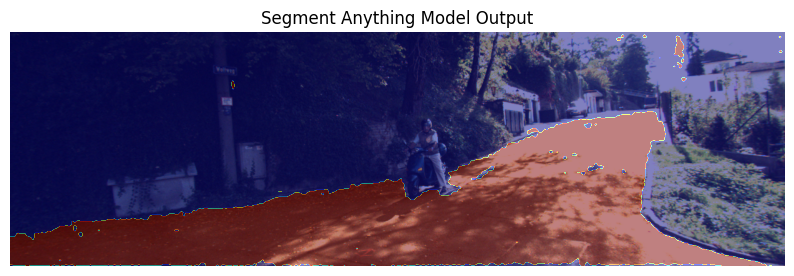

In [ ]:
from transformers import SamModel, SamProcessor
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained SAM model and processor
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Load an image
image_path = r"..\data\KITTI eigen split\test\2011_09_26\2011_09_26_drive_0086_sync\image_02\data\0000000007.png"
raw_image = Image.open(image_path).convert("RGB")

# Define a point prompt
input_points = [[[450, 600]]]  # Shape: (batch_size, point_batch_size, points_per_image, 2)

# Preprocess the image and prompts
inputs = processor(
    raw_image,
    input_points=input_points,
    return_tensors="pt"
).to("cuda")

# Perform segmentation
outputs = model(**inputs)

# Post-process masks
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

# Convert image to NumPy format for visualization
image_np = np.array(raw_image)

# Extract the first mask and ensure it's 2D
mask = masks[0][0][0]

# Visualize the segmentation result
plt.figure(figsize=(10, 10))
plt.imshow(image_np)  # Display the image
plt.imshow(mask, alpha=0.5, cmap="jet")  # Overlay the first mask
plt.axis("off")
plt.title("Segment Anything Model Output")
plt.show()

https://huggingface.co/facebook/sam-vit-base#TL;DR

## TL;DR <a class="anchor" id="last-bullet"></a>

* image similarity hugging face tutorial: https://huggingface.co/blog/image-similarity
* sam overview: https://encord.com/blog/segment-anything-model-explained/
* sam tutorial (using all prompt type inputs): https://towardsdatascience.com/see-what-you-sam-4eea9ad9a5de
* sam on video (eg: deleting predicted persons from scenes): https://github.com/gaomingqi/track-anything
* sam: https://github.com/facebookresearch/segment-anything
